# Example 2: Fault properties from extracted network
This example describes how to calculat the strike and length of faults in a network

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2_fault_properties.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [ ]:
!git clone https://github.com/thilowrona/fault_analysis_toolbox

Cloning into 'fault_analysis_toolbox'...
remote: Enumerating objects: 2057, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 2057 (delta 173), reused 0 (delta 0), pack-reused 1755
Receiving objects: 100% (2057/2057), 343.31 MiB | 26.03 MiB/s, done.
Resolving deltas: 100% (405/405), done.
Checking out files: 100% (1390/1390), done.


In [ ]:
!pip3 install vtk
!pip3 install git+https://github.com/ulikoehler/cv_algorithms.git

     |████████████████████████████████| 103.4MB 53kB/s 
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-req-build-9dcfn1c8
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-req-build-9dcfn1c8
  Created wheel for cv-algorithms: filename=cv_algorithms-1.0.0-cp37-cp37m-linux_x86_64.whl size=43527 sha256=0fdc5c299bb9a2a6ca0faa2b0386ce5c05a0a1fe4a250fed6b882e92304748f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-nm6vueeu/wheels/0b/45/f6/dfa0d535f50a0148a4c7d6912942fdb7a6445d7196a2591cbe
Successfully built cv-algorithms


Now we can load the python packages:

In [ ]:
import math
import numpy as np 
import networkx as nx
import pickle
import matplotlib.pyplot as plt

and the functions from the fault analysis toolbox that we want to use:

In [ ]:
import sys
sys.path.append('/content/fault_analysis_toolbox/code/')

from image_processing import guo_hall
from edits import *
from metrics import *
from plots import *

## Load fault network

First, we load a fault network extracted from an oblique rift model:

In [ ]:
G = pickle.load(open('/content/fault_analysis_toolbox/examples/2-fault_properties/g_27.p', 'rb'))          

Now we can visualize the faults and look at the orientations:

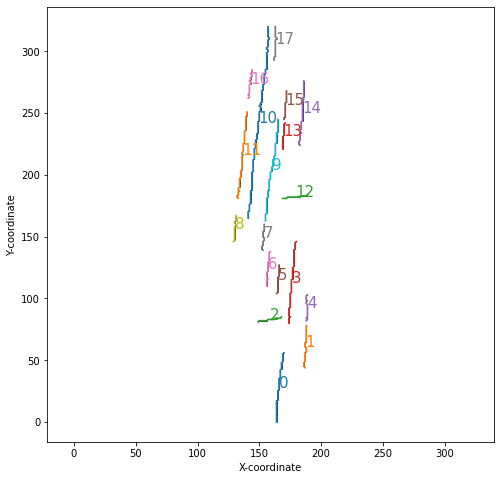

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_components(G, ax, label=True)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()

We can see that most faults are striking N-S and a few E-W. Let's calculate the strike of the edges of the network:

In [ ]:
for edge in G.edges:
  x1 = G.nodes[edge[0]]['pos'][0]
  x2 = G.nodes[edge[1]]['pos'][0]
  y1 = G.nodes[edge[0]]['pos'][1]
  y2 = G.nodes[edge[1]]['pos'][1]

  if (x2-x1)<0:
    G.edges[edge]['strike'] = math.degrees(math.atan2((x2-x1),(y2-y1))) + 360
  else:
    G.edges[edge]['strike'] = math.degrees(math.atan2((x2-x1),(y2-y1)))

Let's plot these strikes as edge attributes using this function:

In [ ]:
def plot_edge_attribute(G, attribute, ax=[]):
    
    if ax==[]:
        fig, ax = plt.subplots() 

    nx.draw(G,
            pos = nx.get_node_attributes(G, 'pos'),
            node_size = 0.001,
            ax=ax)

    nx.draw_networkx_edges(G,
                           pos = nx.get_node_attributes(G, 'pos'),
                           edge_color = np.array([G.edges[edge][attribute] for edge in G.edges]),
                           edge_cmap=plt.cm.twilight_shifted,
                           ax=ax)
    ax.axis('equal')

    # Colorbar
    cmap = plt.cm.twilight_shifted
    vmax = max_value_edges(G, attribute)
    vmin = min_value_edges(G, attribute)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
            
    cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(attribute, rotation=270)

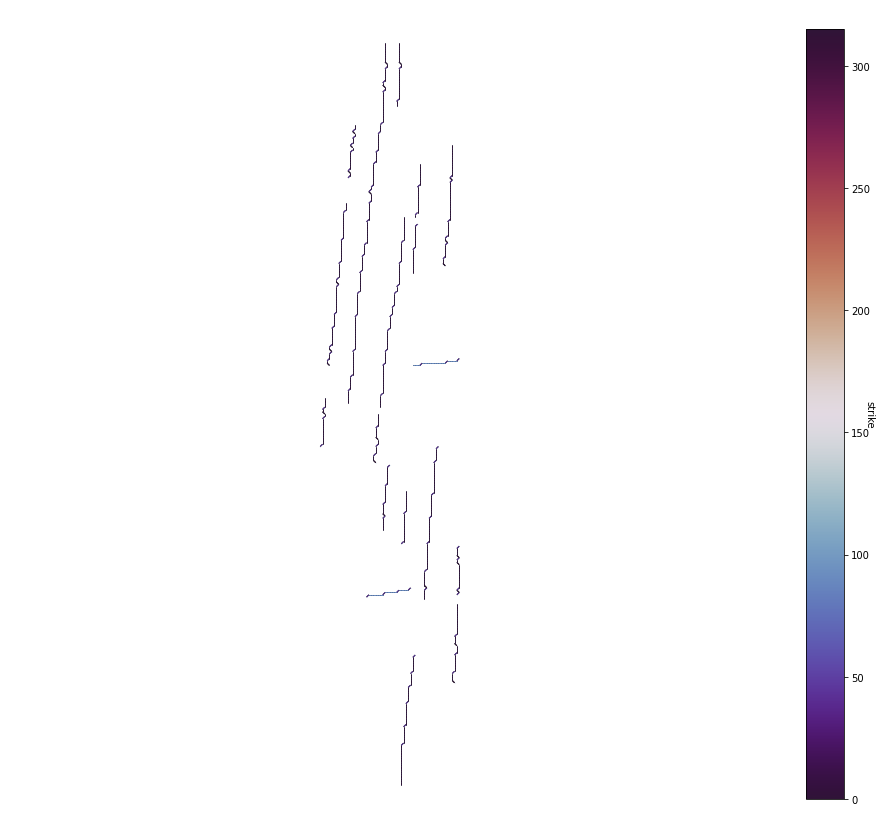

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plot_edge_attribute(G, 'strike', ax)

Looks a bit odd, let's zoom in:

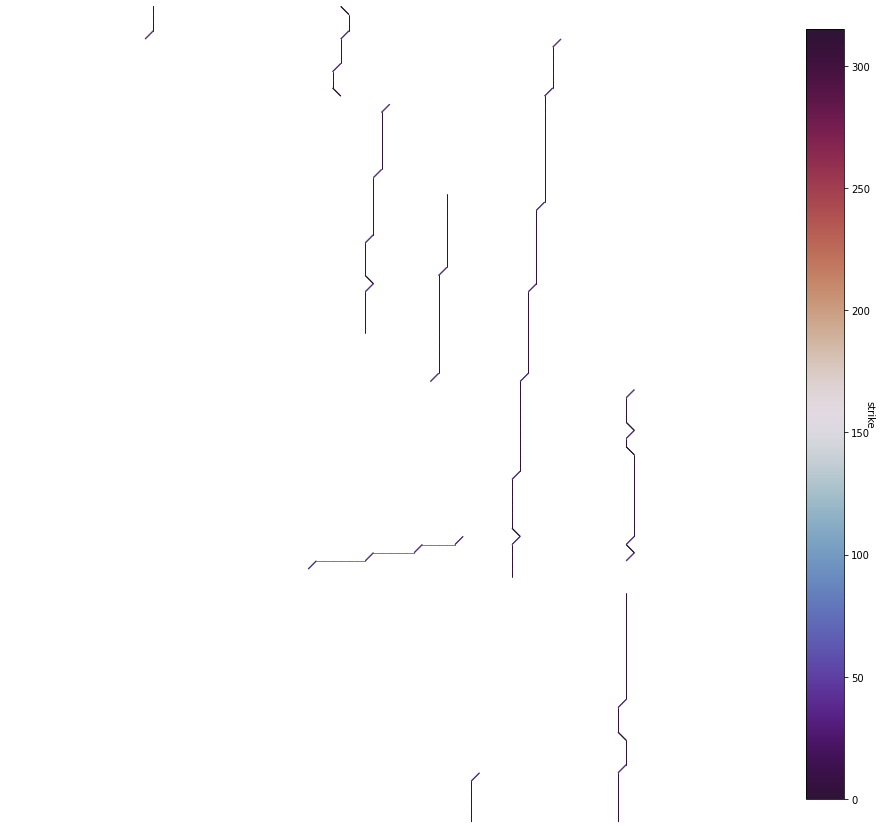

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plot_edge_attribute(G, 'strike', ax)
ax.set_ylim([50, 150])
plt.show()

Okay, the edges have very discrete strikes (0, 45, 90 degrees), because they were extracted from a regular array. This becomes even more evident when we plot the Rose diagram (a polar histogram of the strikes):

In [ ]:
def plot_rose(strikes, lengths=[], ax=[]):    
    
    if lengths ==[]:
        lengths = np.ones_like(np.array(strikes))

    bin_edges = np.arange(-5, 366, 10)
    number_of_strikes, bin_edges = np.histogram(strikes, bin_edges, weights = lengths)           
    number_of_strikes[0] += number_of_strikes[-1]
    half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
    two_halves = np.concatenate([half, half])
    
    cmap = plt.cm.twilight_shifted(np.concatenate((np.linspace(0, 1, 18), np.linspace(0, 1, 18)), axis=0))
     
    if ax==[]:
        fig = plt.figure(figsize=(8,8))
            
        ax = fig.add_subplot(111, projection='polar')
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
    
    ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
           width=np.deg2rad(10), bottom=0.0, color=cmap, edgecolor='k')
    
    #    ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2), angle=0, weight= 'black')
    ax.set_title('Rose Diagram', y=1.10, fontsize=15)
    
    # fig.tight_layout()


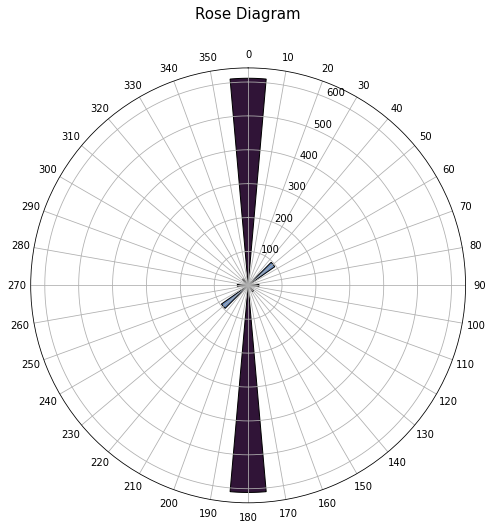

In [ ]:
strikes = [G.edges[edge]['strike'] for edge in G.edges]
plot_rose(strikes)

Okay, that's not really what we want. We want the strikes of the faults, not the edges. So let's calculate those:

In [ ]:
strikes = []
for cc in nx.connected_components(G):
  edges = G.edges(cc)
  edge_strikes = []
  for edge in edges:
    edge_strikes.append(G.edges[edge]['strike'])
  strikes.append(np.mean(edge_strikes))

and the fault lenghts as weights:

In [ ]:
for edge in G.edges:
  G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))

In [ ]:
lengths = []
for cc in nx.connected_components(G):
  edges = G.edges(cc)
  edge_lengths = []
  for edge in edges:
    edge_lengths.append(G.edges[edge]['length'])
  lengths.append(np.mean(edge_lengths))

Now we can plot the Rose diagram again:

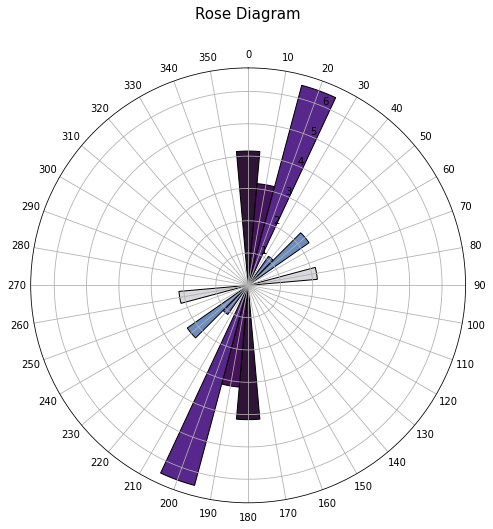

In [ ]:
plot_rose(strikes, lengths)

That's a much better representation of the fault strikes in our network!

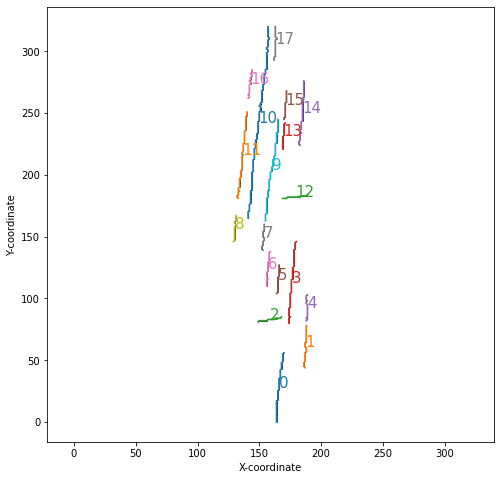

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_components(G, ax, label=True)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()